C:\Users\HEITOR\AppData\Local\Temp\ipykernel_8376\1973686628.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Rooms', y='Price', palette='Blues')


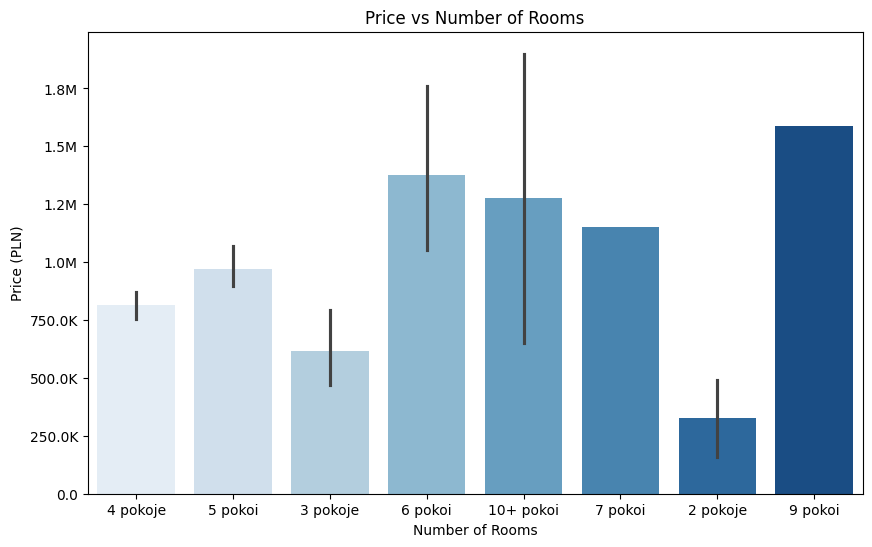

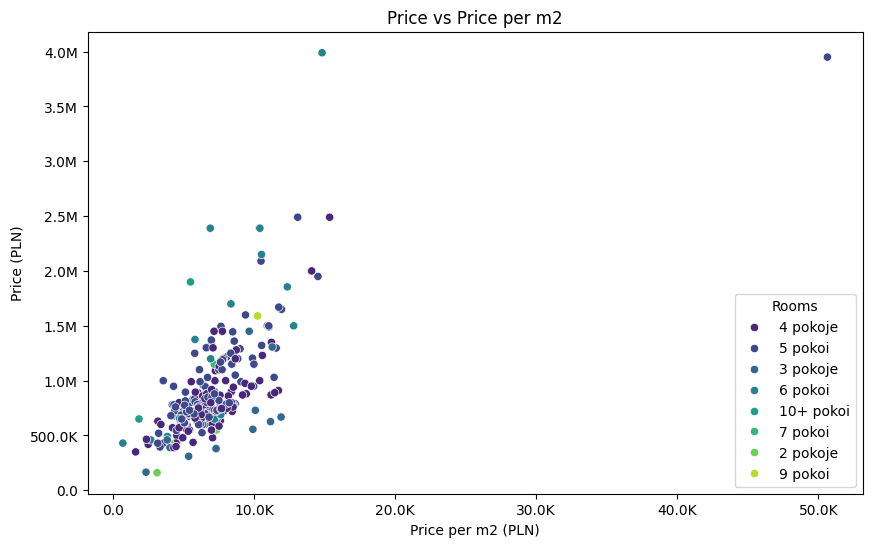

C:\Users\HEITOR\AppData\Local\Temp\ipykernel_8376\1973686628.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Location', y='Price', palette='coolwarm')


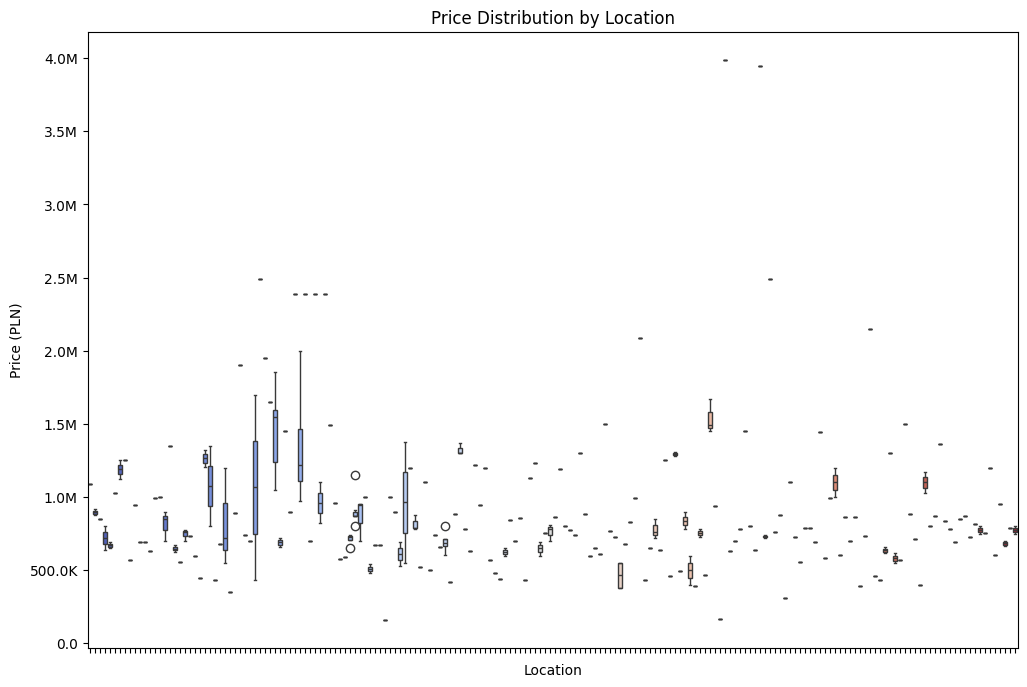

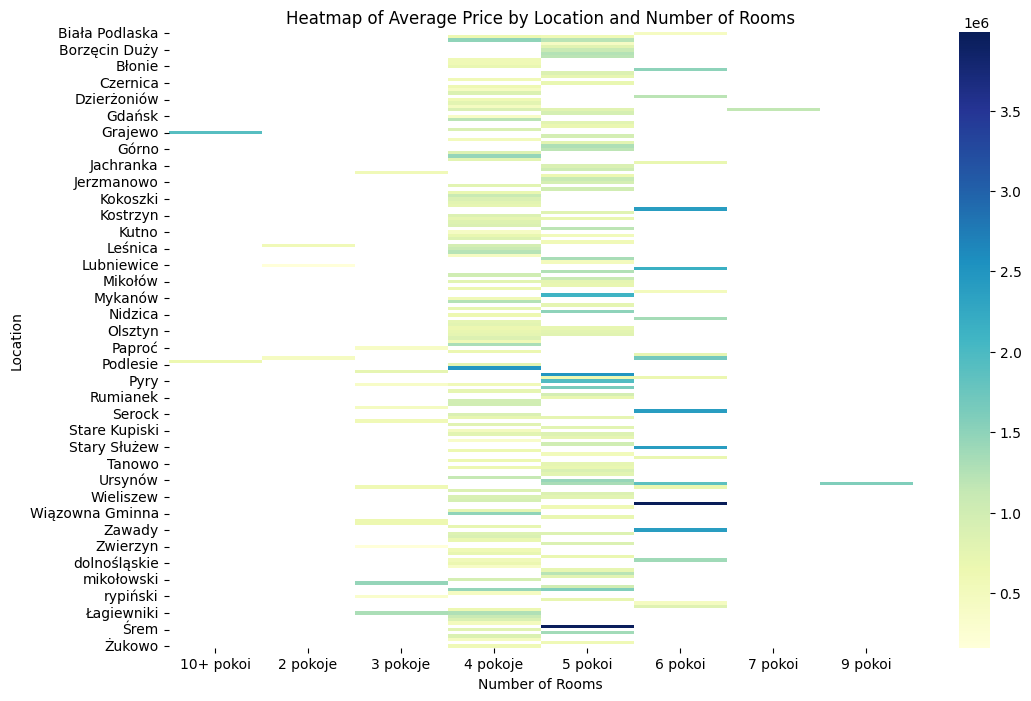

In [44]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

%matplotlib inline

def format_plot(value, tick_number):
    if value >= 1e6:
        return f'{value/1e6:.1f}M'
    elif value >= 1e3:
        return f'{value/1e3:.1f}K'
    else:
        return str(value)

def format_data(price_str):
    normalized_str = unicodedata.normalize("NFKD", price_str)
    cleaned_price = normalized_str.strip().replace('\xa0', '').replace(' ', '').replace('zł', '').replace('m²', '').replace(',', '').replace('/', '').replace('m2', '').replace('/m2', '')
    return cleaned_price

def extract_city(location):
    if location:
        return location.split(',')[1].strip() if len(location.split(',')) > 1 else None
    return None

def fetch_data(page):
    url = f"https://www.otodom.pl/pl/wyniki/sprzedaz/dom%2Crynek-pierwotny/cala-polska?page={page}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        "Connection": "keep-alive",
    }

    res = requests.get(url, headers=headers)
    if res.status_code == 200:
        html = res.text
        soup = BeautifulSoup(html, 'html.parser')
        
        main_div = soup.find_all('div', class_='ef1jqb1')
        if main_div:
            lists = main_div[0].find_all('ul')
            
            result_data = []
            for lst in lists:
                list_items = lst.find_all('li')
                for item in list_items:
                    item_data = {}
                    
                    spans = item.find_all('span')
                    if spans:
                        price_text = spans[-1].text
                        formatted_price = format_data(price_text)
                        if formatted_price[0] not in ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0"]:
                            continue  
                        item_data['price'] = formatted_price
                    else:
                        item_data['price'] = None
                    
                    dl = item.find('dl')
                    if dl is not None:
                        dd = dl.find_all('dd')
                        if dd:
                            item_data['rooms'] = dd[0].text.strip() if len(dd) > 0 else None
                            item_data['price_per_square_meter'] = format_data(dd[-1].text) if len(dd) > 1 else None
                        else:
                            item_data['rooms'] = None
                            item_data['price_per_square_meter'] = None
                    else:
                        item_data['rooms'] = None
                        item_data['price_per_square_meter'] = None
                    
                    paragraphs = item.find_all('p')
                    location = paragraphs[-1].text.strip() if paragraphs else None
                    item_data['location'] = extract_city(location)
                    
                    a = item.find('a', href=True)
                    item_data['url'] = "https://www.otodom.pl" + a['href'] if a else None
                    
                    result_item = {
                        'Price': item_data['price'],
                        'Price per m2': item_data['price_per_square_meter'],
                        'Rooms': item_data['rooms'],
                        'Location': item_data['location'],
                    }
                    if all(value is not None for value in item_data.values()):
                        result_data.append(result_item)
            
            return result_data
    else:
        print(f"Failed to retrieve the webpage. Status code: {res.status_code}")
        return []

def save_to_csv(data, filename='output.csv'):
    df = pd.DataFrame(data)
    df = df.dropna()
    df.to_csv(filename, index=False, encoding='utf-8')

all_data = []
for i in range(1, 10):
    page_data = fetch_data(i)
    all_data.extend(page_data)
save_to_csv(all_data)

df = pd.DataFrame(all_data)
df['Price'] = pd.to_numeric(df['Price'])
df['Price per m2'] = pd.to_numeric(df['Price per m2'])

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Rooms', y='Price', palette='Blues')
plt.title('Price vs Number of Rooms')
plt.ylabel('Price (PLN)')
plt.xlabel('Number of Rooms')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_plot))
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Price per m2', y='Price', hue='Rooms', palette='viridis')
plt.title('Price vs Price per m2')
plt.ylabel('Price (PLN)')
plt.xlabel('Price per m2 (PLN)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_plot))
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_plot))
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Location', y='Price', palette='coolwarm')
plt.title('Price Distribution by Location')
plt.ylabel('Price (PLN)')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_plot))
plt.gca().set_xticklabels([])
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.pivot_table(index='Location', columns='Rooms', values='Price', aggfunc='mean'), annot=False, fmt=".1f", cmap='YlGnBu')
plt.title('Heatmap of Average Price by Location and Number of Rooms')
plt.ylabel('Location')
plt.xlabel('Number of Rooms')
plt.show()



C:\Users\HEITOR\AppData\Local\Temp\ipykernel_8376\1499408808.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Price Range', palette='Blues')


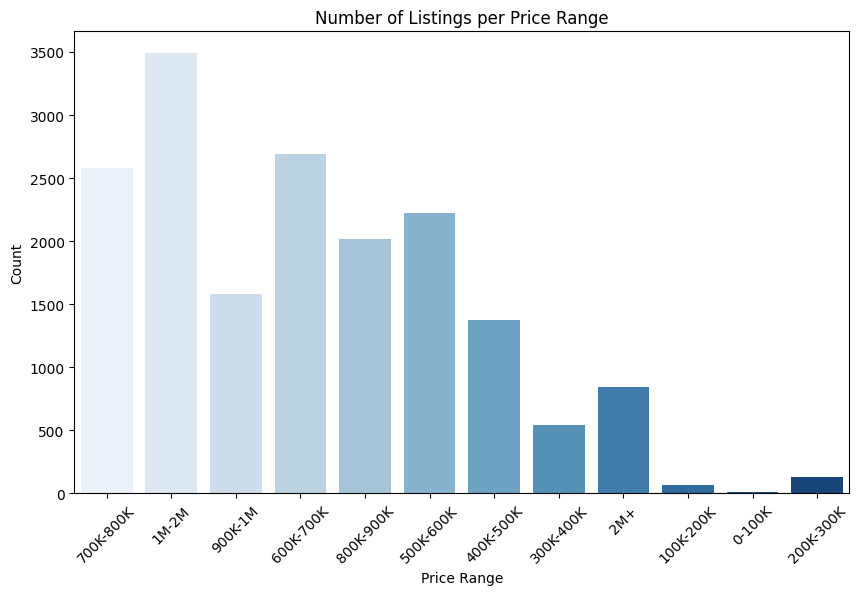

C:\Users\HEITOR\AppData\Local\Temp\ipykernel_8376\1499408808.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Price Range', y='Price per m2', palette='coolwarm')


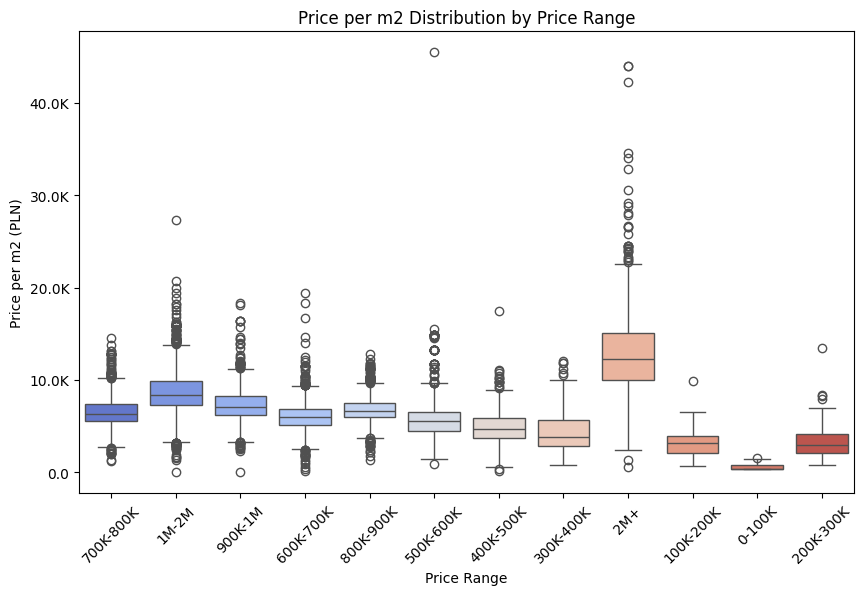

C:\Users\HEITOR\AppData\Local\Temp\ipykernel_8376\1499408808.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Price Range', y='Rooms', palette='viridis')


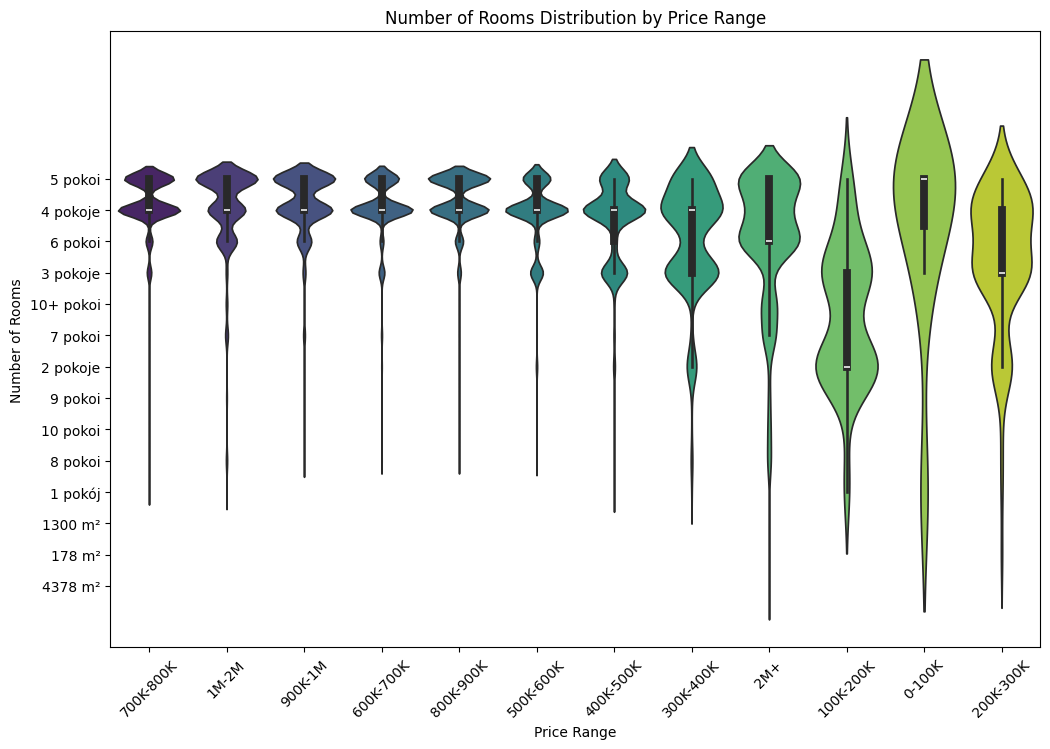

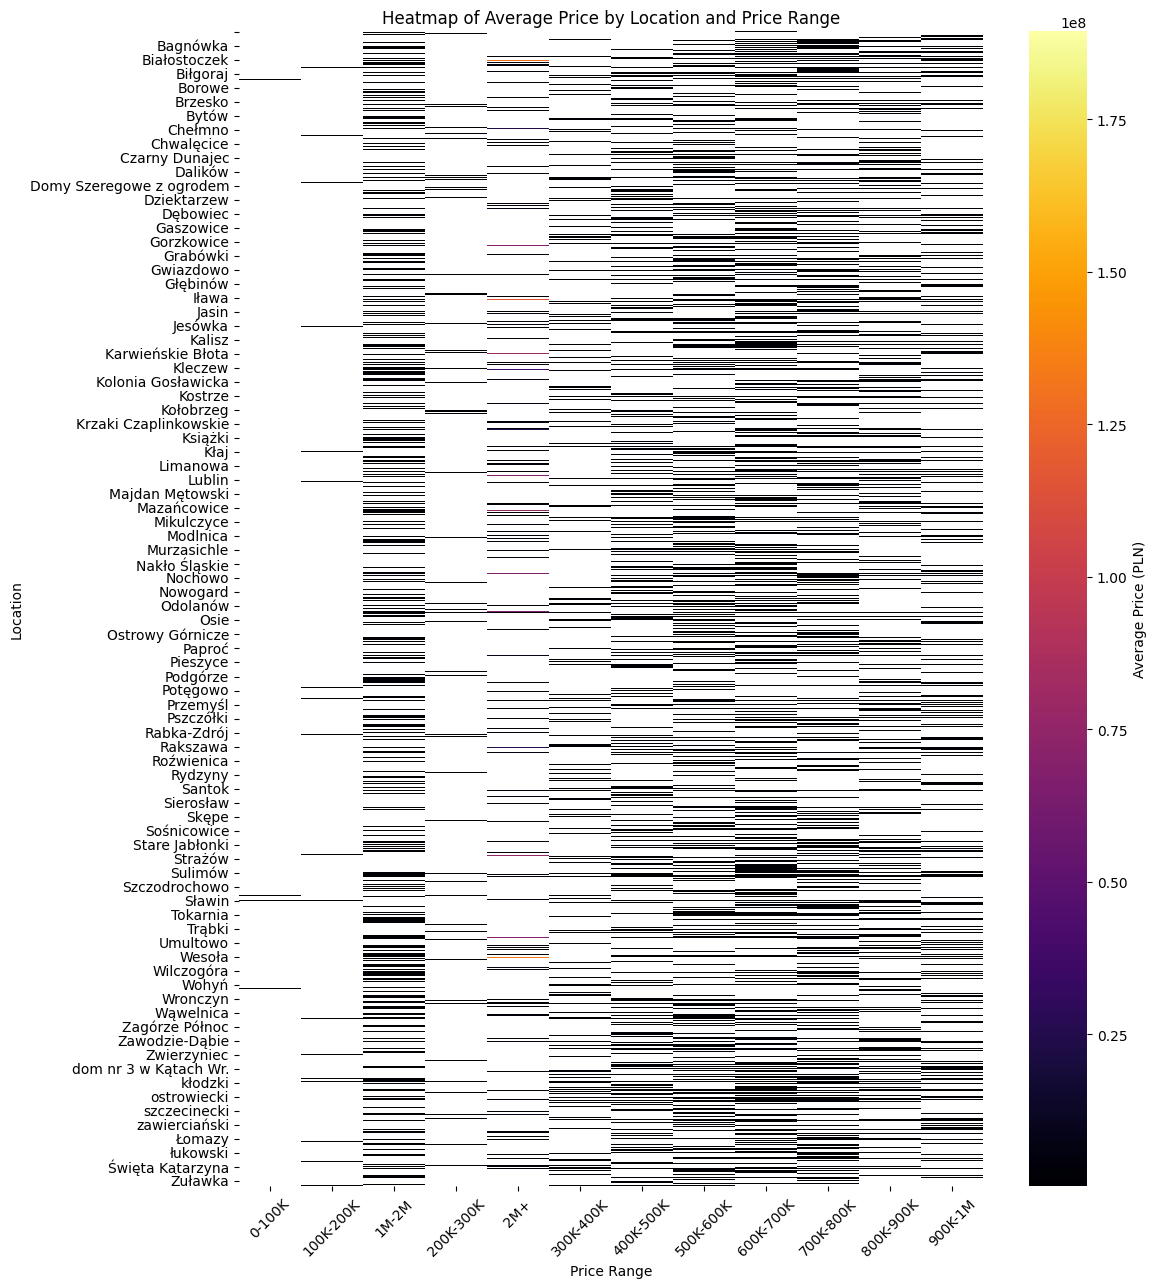

C:\Users\HEITOR\AppData\Local\Temp\ipykernel_8376\1499408808.py:184: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='Rooms', y='Price', palette='viridis')


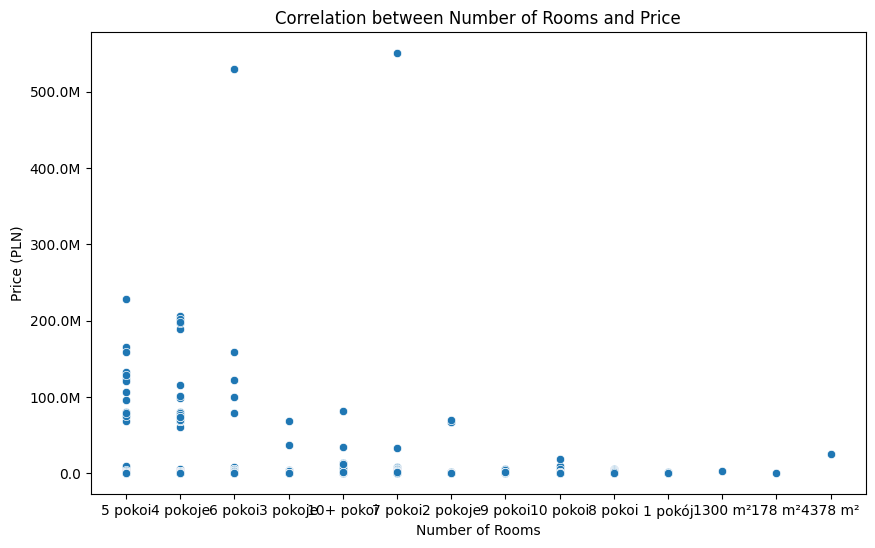

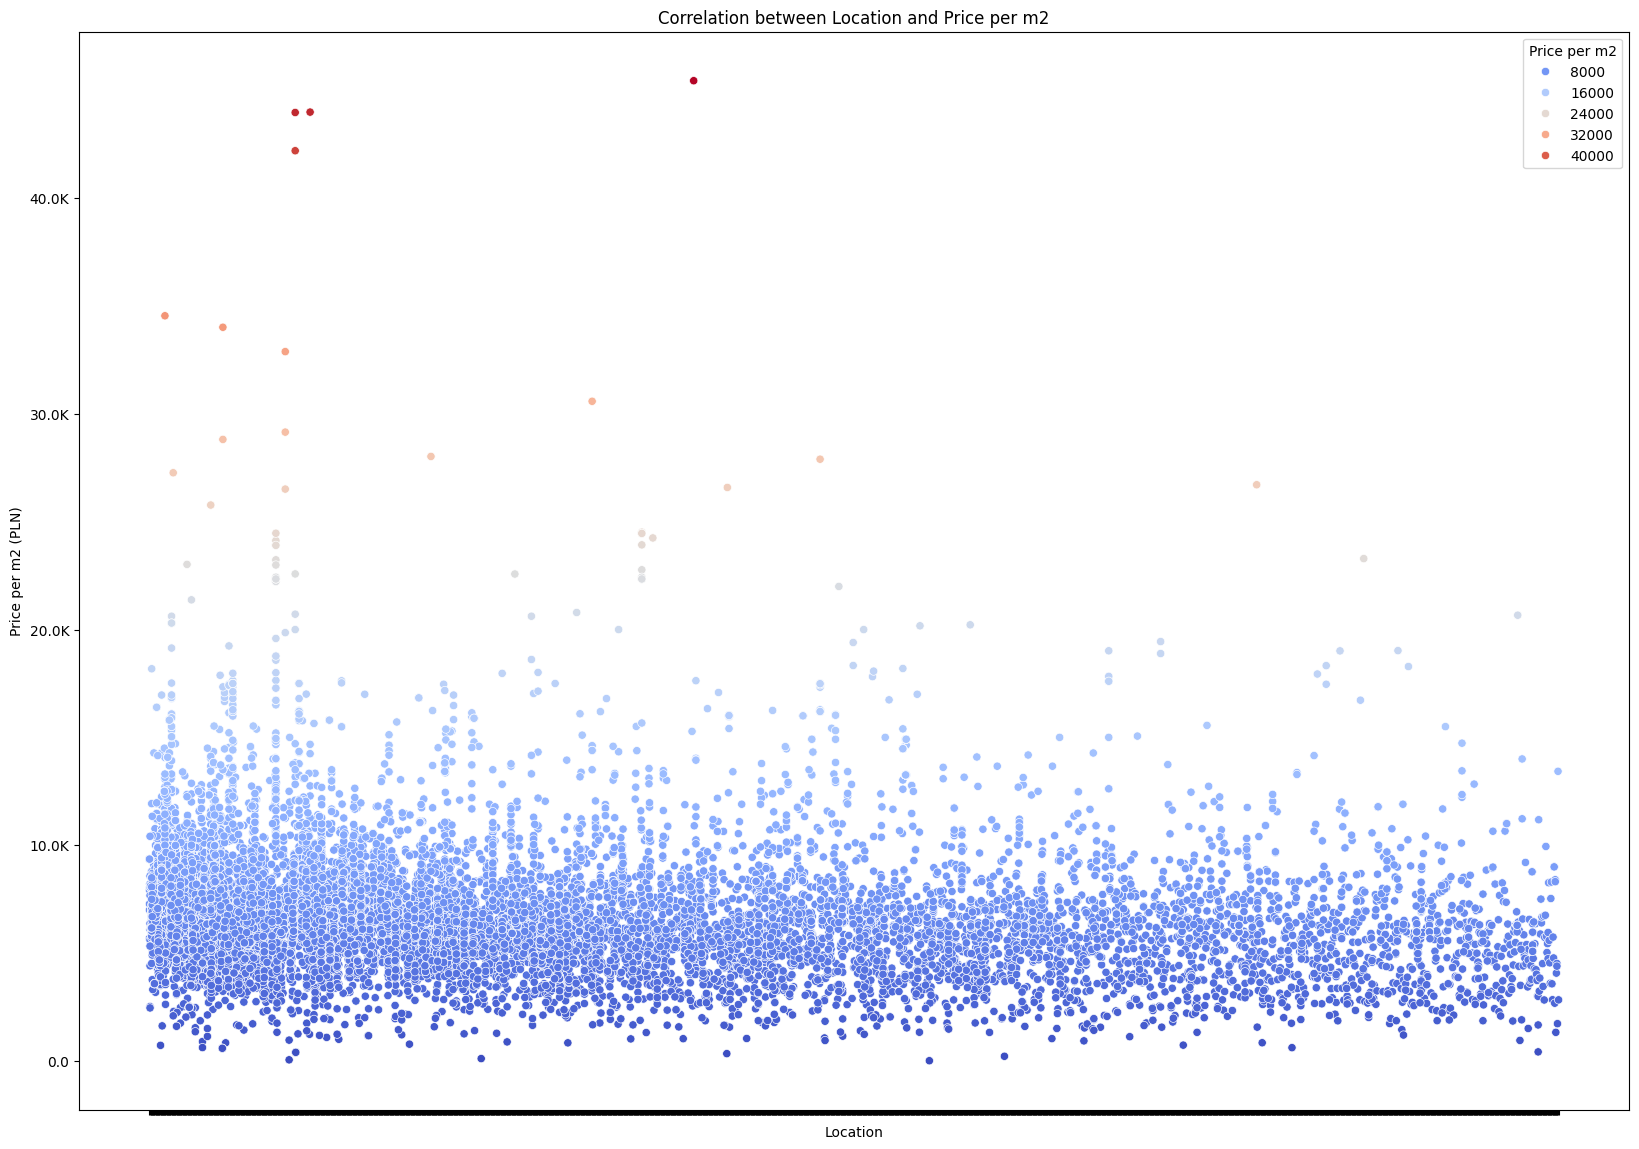

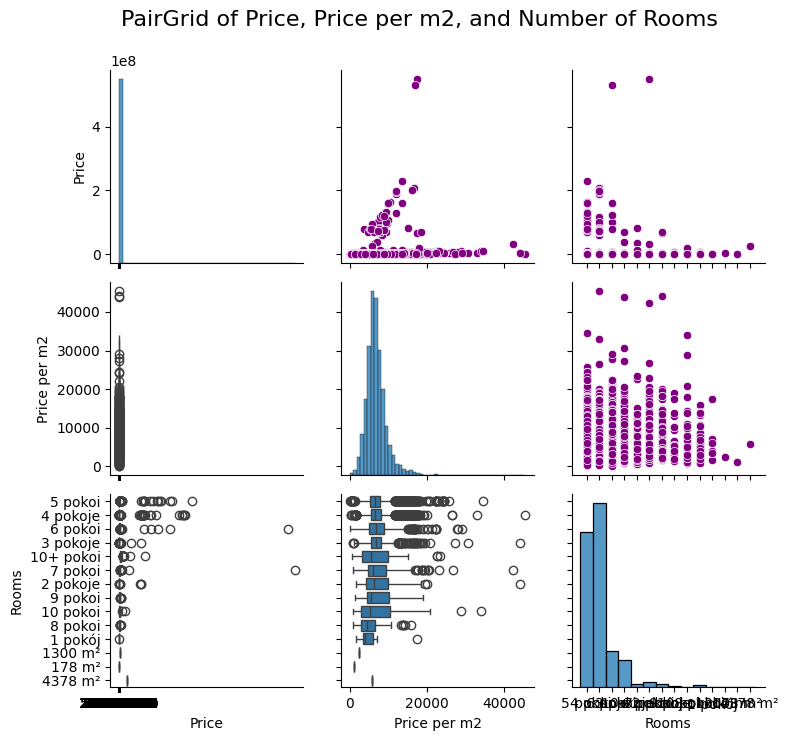

In [43]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

%matplotlib inline

def format_plot(value, tick_number):
    if value >= 1e6:
        return f'{value/1e6:.1f}M'
    elif value >= 1e3:
        return f'{value/1e3:.1f}K'
    else:
        return str(value)

def format_data(price_str):
    normalized_str = unicodedata.normalize("NFKD", price_str)
    cleaned_price = normalized_str.strip().replace('\xa0', '').replace(' ', '').replace('zł', '').replace('m²', '').replace(',', '').replace('/', '').replace('m2', '').replace('/m2', '').replace('€', '')
    return cleaned_price

def extract_city(location):
    if location:
        return location.split(',')[1].strip() if len(location.split(',')) > 1 else None
    return None

def fetch_data(page):
    url = f"https://www.otodom.pl/pl/wyniki/sprzedaz/dom%2Crynek-pierwotny/cala-polska?page={page}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        "Connection": "keep-alive",
    }

    res = requests.get(url, headers=headers)
    if res.status_code == 200:
        html = res.text
        soup = BeautifulSoup(html, 'html.parser')
        
        main_div = soup.find_all('div', class_='ef1jqb1')
        if main_div:
            lists = main_div[0].find_all('ul')
            
            result_data = []
            for lst in lists:
                list_items = lst.find_all('li')
                for item in list_items:
                    item_data = {}
                    
                    spans = item.find_all('span')
                    if spans:
                        price_text = spans[-1].text
                        formatted_price = format_data(price_text)
                        if formatted_price[0] not in ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0"]:
                            continue  
                        item_data['price'] = formatted_price
                    else:
                        item_data['price'] = None
                    
                    dl = item.find('dl')
                    if dl is not None:
                        dd = dl.find_all('dd')
                        if dd:
                            item_data['rooms'] = dd[0].text.strip() if len(dd) > 0 else None
                            item_data['price_per_square_meter'] = format_data(dd[-1].text) if len(dd) > 1 else None
                        else:
                            item_data['rooms'] = None
                            item_data['price_per_square_meter'] = None
                    else:
                        item_data['rooms'] = None
                        item_data['price_per_square_meter'] = None
                    
                    paragraphs = item.find_all('p')
                    location = paragraphs[-1].text.strip() if paragraphs else None
                    item_data['location'] = extract_city(location)
                    
                    a = item.find('a', href=True)
                    item_data['url'] = "https://www.otodom.pl" + a['href'] if a else None
                    
                    result_item = {
                        'Price': item_data['price'],
                        'Price per m2': item_data['price_per_square_meter'],
                        'Rooms': item_data['rooms'],
                        'Location': item_data['location'],
                    }
                    if all(value is not None for value in item_data.values()):
                        result_data.append(result_item)
            
            return result_data
    else:
        print(f"Failed to retrieve the webpage. Status code: {res.status_code}")
        return []

def save_to_csv(data, filename='output.csv'):
    df = pd.DataFrame(data)
    df = df.dropna()
    df.to_csv(filename, index=False, encoding='utf-8')

all_data = []
for i in range(1, 492):
    page_data = fetch_data(i)
    all_data.extend(page_data)
save_to_csv(all_data)

df = pd.DataFrame(all_data)
df['Price'] = pd.to_numeric(df['Price'])
df['Price per m2'] = pd.to_numeric(df['Price per m2'])

df = df[df['Price per m2'] <= 50_000]

def categorize_price(price):
    if price < 100_000:
        return '0-100K'
    elif price < 200_000:
        return '100K-200K'
    elif price < 300_000:
        return '200K-300K'
    elif price < 400_000:
        return '300K-400K'
    elif price < 500_000:
        return '400K-500K'
    elif price < 600_000:
        return '500K-600K'
    elif price < 700_000:
        return '600K-700K'
    elif price < 800_000:
        return '700K-800K'
    elif price < 900_000:
        return '800K-900K'
    elif price < 1_000_000:
        return '900K-1M'
    elif price < 2_000_000:
        return '1M-2M'
    else:
        return '2M+'

df['Price Range'] = df['Price'].apply(categorize_price)

# Listings/Price Range
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Price Range', palette='Blues')
plt.title('Number of Listings per Price Range')
plt.ylabel('Count')
plt.xlabel('Price Range')
plt.xticks(rotation=45)
plt.show()

# Price/m² per Price Range
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Price Range', y='Price per m2', palette='coolwarm')
plt.title('Price per m2 Distribution by Price Range')
plt.ylabel('Price per m2 (PLN)')
plt.xlabel('Price Range')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_plot))
plt.show()

# Number of Rooms/Price Range
plt.figure(figsize=(12, 8))
sns.violinplot(data=df, x='Price Range', y='Rooms', palette='viridis')
plt.title('Number of Rooms Distribution by Price Range')
plt.ylabel('Number of Rooms')
plt.xlabel('Price Range')
plt.xticks(rotation=45)
plt.show()

# Heatmap (Avg Price/Location and Price Range)
plt.figure(figsize=(12, 15))
heatmap_data = df.pivot_table(index='Location', columns='Price Range', values='Price', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='inferno', cbar_kws={'label': 'Average Price (PLN)'}, annot=False)
plt.title('Heatmap of Average Price by Location and Price Range')
plt.ylabel('Location')
plt.xlabel('Price Range')
plt.xticks(rotation=45)
plt.show()

# Correlation

# Number of Rooms/Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Rooms', y='Price', palette='viridis')
plt.title('Correlation between Number of Rooms and Price')
plt.xlabel('Number of Rooms')
plt.ylabel('Price (PLN)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_plot))
plt.show()

# Location/Price/m²
plt.figure(figsize=(20, 14))
scatter = sns.scatterplot(data=df, x='Location', y='Price per m2', hue='Price per m2', palette='coolwarm')
plt.title('Correlation between Location and Price per m2')
plt.xlabel('Location')
plt.ylabel('Price per m2 (PLN)')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_plot))
plt.gca().set_xticklabels([])  
plt.legend(title='Price per m2')
plt.show()

# Pairgrid
pairgrid = sns.PairGrid(df, vars=['Price', 'Price per m2', 'Rooms'], diag_sharey=False)

pairgrid.map_upper(sns.scatterplot, color='purple')
pairgrid.map_lower(sns.boxplot, palette='cool_d')
pairgrid.map_diag(sns.histplot, bins=50)

plt.subplots_adjust(top=0.9)
pairgrid.fig.suptitle('PairGrid of Price, Price per m2, and Number of Rooms', fontsize=16)
plt.show()

<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
C:\Users\HEITOR\AppData\Local\Temp\ipykernel_8376\3923835453.py:43: SyntaxWarning: invalid escape sequence '\d'
  df['Rooms'] = df['Rooms'].str.extract('(\d+)').astype(int)


     Price  Price per m2     Rooms          Location
0  1090000          7267  4 pokoje         Kobylanka
1   895000          6823  4 pokoje           Zerwana
2   850000          6439   5 pokoi         Chmielnik
3   799000          5936  4 pokoje  Nadolice Wielkie
4   649000          6187  4 pokoje  Tarnowo Podgórne
              Price  Price per m2
count  2.620000e+02    262.000000
mean   9.152138e+05   7161.629771
std    4.912281e+05   3630.290871
min    1.600000e+05    717.000000
25%    6.512500e+05   5278.000000
50%    7.800000e+05   6727.500000
75%    1.021750e+06   8337.250000
max    3.990000e+06  50641.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Price         262 non-null    int64 
 1   Price per m2  262 non-null    int64 
 2   Rooms         262 non-null    object
 3   Location      262 non-null    object
dtypes: int64(2), ob

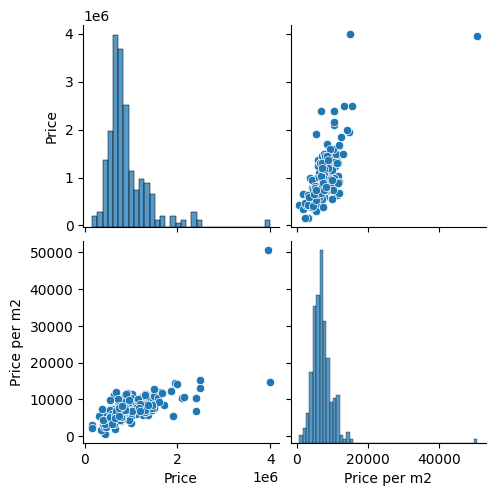

Coeficiente:  [95.1106981]
Intercepto:  236008.28893723444
Erro quadrático médio:  81405342856.05035
R²:  0.36987578544401256


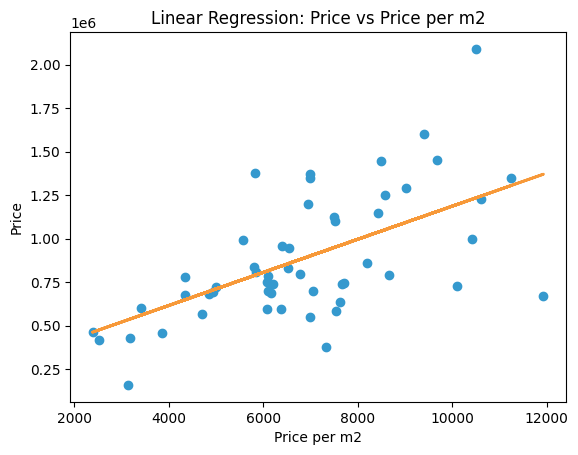

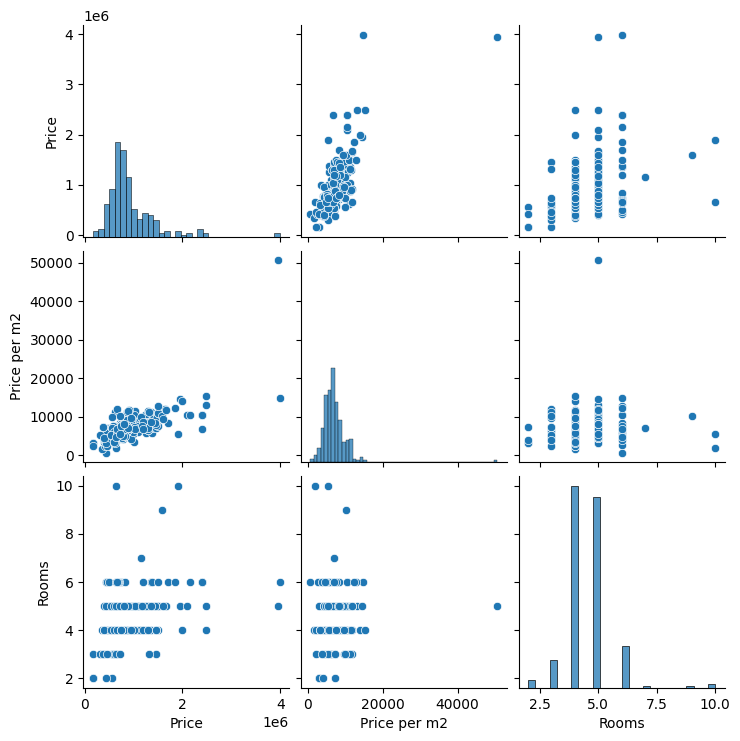

Coeficiente:  [180934.04204232]
Intercepto:  92281.5624655016
Erro quadrático médio:  108758071304.80794
R²:  0.158149921698012


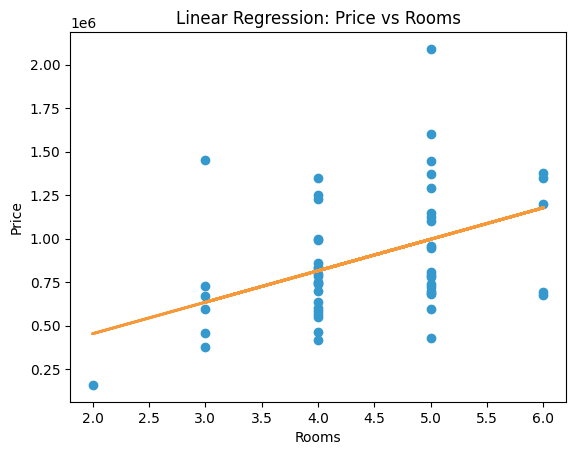

In [51]:
# Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('output.csv')

print(df.head())
print(df.describe())
print(df.info())

# Price vs Price/m²
sns.pairplot(df)
plt.show()

X = df[['Price per m2']]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print("Coeficiente: ", regressor.coef_)
print("Intercepto: ", regressor.intercept_)
print("Erro quadrático médio: ", mean_squared_error(y_test, y_pred))
print("R²: ", r2_score(y_test, y_pred))

plt.scatter(X_test, y_test, color='#3599CE')
plt.plot(X_test, y_pred, color='#F79939', linewidth=2)
plt.xlabel('Price per m2')
plt.ylabel('Price')
plt.title('Linear Regression: Price vs Price per m2')
plt.show()

# Price vs Number of Rooms
df['Rooms'] = df['Rooms'].str.extract('(\d+)').astype(int)

sns.pairplot(df)
plt.show()

X = df[['Rooms']]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print("Coeficiente: ", regressor.coef_)
print("Intercepto: ", regressor.intercept_)
print("Erro quadrático médio: ", mean_squared_error(y_test, y_pred))
print("R²: ", r2_score(y_test, y_pred))

plt.scatter(X_test, y_test, color='#3599CE')
plt.plot(X_test, y_pred, color='#F79939', linewidth=2)
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Linear Regression: Price vs Rooms')
plt.show()